# Part I:  Research Question
## A.  Describe the purpose of this data analysis by doing the following:
### 1.  Summarize one research question that is relevant to a real-world organizational situation captured in the selected data set and that you will answer using time series modeling techniques.

Being able to understand patterns and trends in revenue and sales can help prepare executives when making decisions about the future. When developing a strategy, considering what might happen in the days, weeks, or months ahead is essential as cash coming in and out of the company can change regularly based on market demand, seasonal shifts, and various factors. Acting on strategies and then seeing revenue drop puts companies at risk as expenditures rise and available cash drops. However, failing to act on risks might mean a loss of market share and new potential sources of revenue.

With revenue data from the last two years, is it possible to forecast 180 days into the future to better equip decision-makers in planning strategies for that time frame?

### 2.  Define the objectives or goals of the data analysis. Ensure that your objectives or goals are reasonable within the scope of the scenario and are represented in the available data.

This analysis' primary objective is to create a forecast of the next 180 days of revenue.

An ARIMA model of the data needs to be made to accomplish that goal. To achieve that objective, the following checks need to be made:
1.	Establish that the data is stationary; if not, make it stationary.
2.	Find any seasonal components to the data
3.	Find the best order for the ARIMA model
4.	Develop a model using the training data and verify it with the test data
5.	Apply the model to the provided data set and forecast revenue 180 days into the future

# Part II:  Method Justification
## B.  Summarize the assumptions of a time series model including stationarity and autocorrelated data.

The time series model in this analysis is an ARIMA model. ARIMA models assume the data is stationary, showing no trends or irregular patterns.

Stationary data means that the distribution of the data doesn’t change over time and its mean, variance, and autocorrelation are constant

A time series model examines one set of values over time and is assumed to be univariate.


In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#import statsmodels.api as sm
from scipy import signal
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller #, acf, pacf, 
#from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [283]:
df = pd.read_csv('teleco_time_series .csv')
df.index = pd.date_range(start='1/1/2020', periods=len(df.index), freq='D')
df = df.drop(columns='Day')
clean_df = df
clean_df = clean_df.diff()
clean_df.dropna(inplace=True)
train_df, test_df = train_test_split(clean_df, test_size=.2, train_size=.8, shuffle=False, stratify=None)

In [284]:
df = pd.read_csv('teleco_time_series .csv')

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


In [286]:
df['Day'].nunique()

731

In [287]:
df['Day'].sort_values()

0        1
1        2
2        3
3        4
4        5
      ... 
726    727
727    728
728    729
729    730
730    731
Name: Day, Length: 731, dtype: int64

In [288]:
df.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,9.822901
std,211.165812,3.852645
min,1.000000,0.000000
25%,183.500000,6.872836
50%,366.000000,10.785571
75%,548.500000,12.566911
max,731.000000,18.154769


In [289]:
df.index = pd.date_range(start='1/1/2020', periods=len(df.index), freq='D')
df = df.drop(columns='Day')

# Part III:  Data Preparation
## C.  Summarize the data cleaning process by doing the following:
### 1.  Provide a line graph visualizing the realization of the time series.

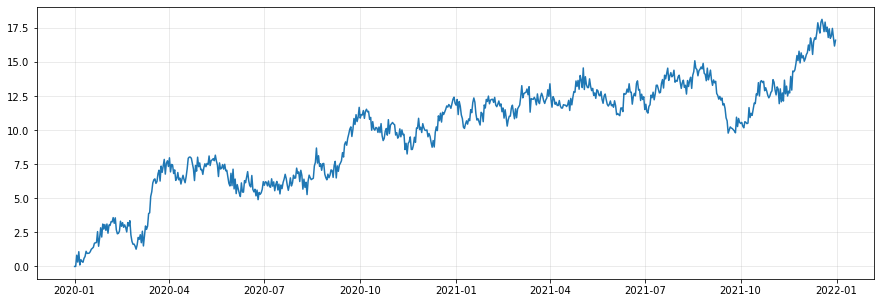

In [290]:
plt.figure(figsize=(15,5))
plt.plot(df)
plt.grid(alpha=.3);

### 2.  Describe the time step formatting of the realization, including any gaps in measurement and the length of the sequence.
The time series is a dataset of revenue data over 731 days. An examination of summaries of the data shows there are no null values, and the ‘Day’ values are each unique and progress from 1 to 731. There are no gaps or missing values for days or revenue values.


In [291]:
dft = adfuller(df)

print('Dickey-Fuller Test for Inital Data')
print('Test Statistic = ', dft[0]) 
print('p-value = ', dft[1]) 
print('Lags Used = ', dft[2]) 
print('Observations Used = ', dft[3])
print('Critical Values ', dft[4])

Dickey-Fuller Test for Inital Data
Test Statistic =  -1.9246121573101798
p-value =  0.32057281507939817
Lags Used =  1
Observations Used =  729
Critical Values  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


### 3.  Evaluate the stationarity of the time series.
A quick visual study of the time series seems to indicate the data is non-stationary, as the values for revenue increase steadily over time.
A Dickey Fuller test of the initial data frame returns a test statistic of -.195, and a p-value of .321. A p-value greater than .05 would confirm the data is non-stationary.

In [292]:
clean_df = df
clean_df = clean_df.diff()
clean_df.dropna(inplace=True)

In [293]:
dft = adfuller(clean_df)

print('Dickey-Fuller Test for Cleaned Data')
print('Test Statistic = ', dft[0]) 
print('p-value = ', dft[1]) 
print('Lags Used = ', dft[2]) 
print('Observations Used = ', dft[3])
print('Critical Values ', dft[4])

Dickey-Fuller Test for Cleaned Data
Test Statistic =  -44.874527193875984
p-value =  0.0
Lags Used =  0
Observations Used =  729
Critical Values  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


### 4.  Explain the steps used to prepare the data for analysis, including the training and test set split.
Before running an ARIMA model on this data, it must be made stationary. A differencing calculation on the ‘Revenue’ data takes the difference between one row and its predecessor. The result is a data set of stationary values and one null value in the first row.

By dropping the null row, the now differenced data is clean and ready for modeling.

A Dickey-Fuller test on the stationary data returns a test statistic of -44.87 and a p-value of 0. The lower the test statistic, the more stationary the data is; a p-value below .05 confirms that.

A plot of the stationary data reveals a time series with a regular pattern of values and no increasing or decreasing trends. 


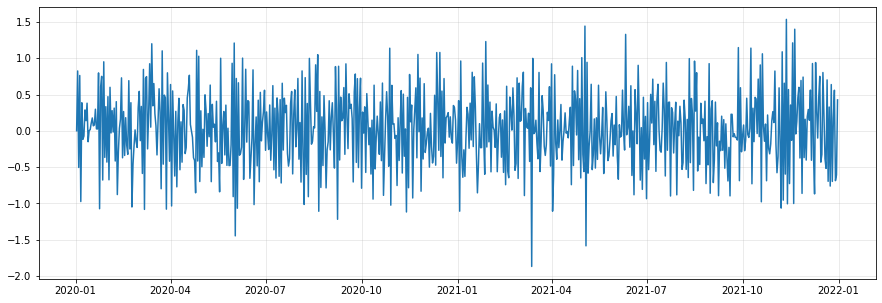

In [294]:
plt.figure(figsize=(15,5))
plt.plot(clean_df)
plt.grid(alpha=.3);

Next, the data is split into a training set and a testing set to confirm predictions made in the ARIMA model. The first 80% of the cleaned data will make up the training data. The test data set is made of the remaining 20%.

In [295]:
train_df, test_df = train_test_split(clean_df, test_size=.2,
                                     train_size=.8, shuffle=False, stratify=None)

In [296]:
train_df.describe()

,Revenue
count,584.000000
mean,0.023433
std,0.526386
min,-1.869719
25%,-0.354053
50%,0.035721
75%,0.388925
max,1.442980


In [297]:
test_df.describe()

,Revenue
count,146.000000
mean,0.020109
std,0.572432
min,-1.065162
25%,-0.399157
50%,-0.041524
75%,0.412637
max,1.536069


### 5.  Provide a copy of the cleaned dataset.

In [298]:
clean_df.to_csv("Stationary_data_D213_Task1.csv")
train_df.to_csv("Test_data_D213_Task1.csv")
test_df.to_csv("Train_data_D213_Task1.csv")

# Part IV:  Model Identification and Analysis
## D.  Analyze the time series dataset by doing the following:
### 1.  Report the annotated findings with visualizations of your data analysis, including the following elements:
- the presence or lack of a seasonal component
- trends
- auto correlation function
- spectral density
- the decomposed time series
- confirmation of the lack of trends in the residuals of the decomposed series

####  auto correlation function
The plot of the Autocorrelation (ACF) of the cleaned data and the Partial Autocorrelation each show a quick drop in correlation within the first values. Based on these criteria, an AR(1) model would be best for an initial ARIMA forecast model with an order of (1,0,0) 
#### the presence or lack of a seasonal component
Additionally, the ACF and PACF plots have autocorrelation values that exceed the confidence intervals. On the PACF plot, it appears to happen at patterned intervals indicating there may be a seasonality to the data.


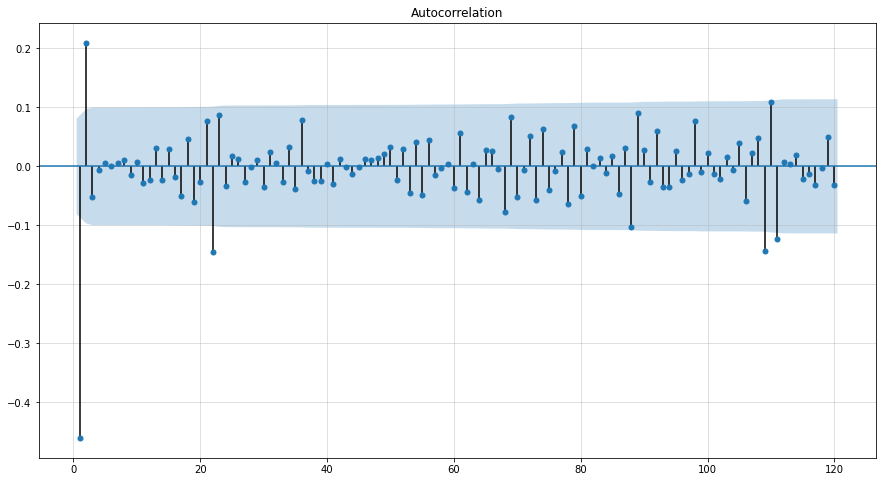

In [299]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_acf(train_df, lags=120, zero=False, ax=ax)
plt.grid(alpha=.5)
plt.show()

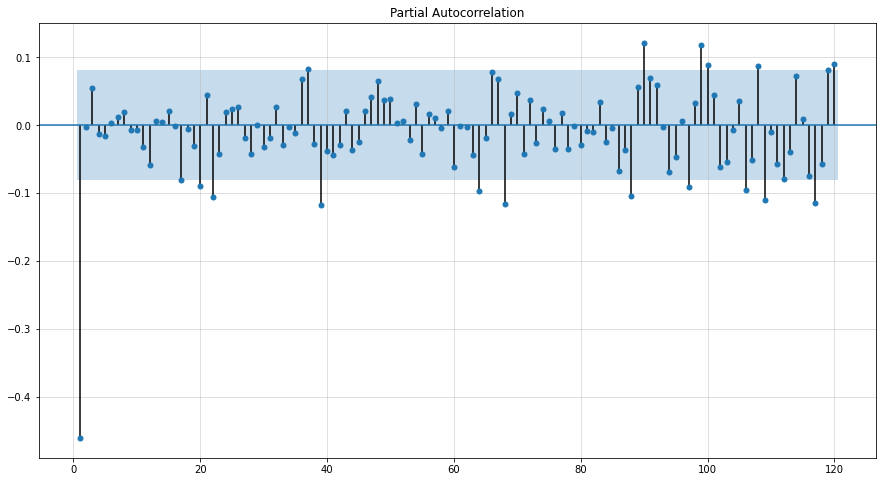

In [300]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_pacf(train_df, lags=120, zero=False, ax=ax)
plt.grid(alpha=.5)
plt.show()

#### trends
The cleaned data set should not have any trend in the stationary data. There is no clear increase or decrease in the data. A plot of the rolling average for the data confirms the mean values for the differenced data over time do not change significantly enough to indicate a trend

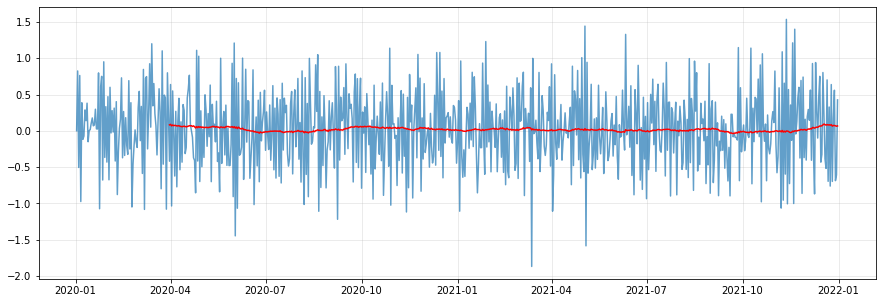

In [301]:
plt.figure(figsize=(15,5))

plt.plot(clean_df, alpha=.7)

plt.plot(clean_df.rolling(window=90).mean(), c='r')

plt.grid(alpha=.3);

#### Spectral Density

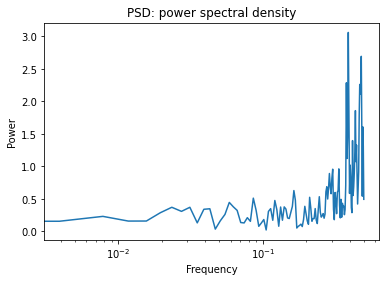

In [302]:
freqs, psd = signal.welch(train_df['Revenue'])

plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

#### the decomposed time series
Using the lag values identified in the PACF plot as a potential seasonal period, the seasonal plot of the decomposed data reveals a consistent pattern at 90 lags within the data. It indicates a seasonal component to the data.

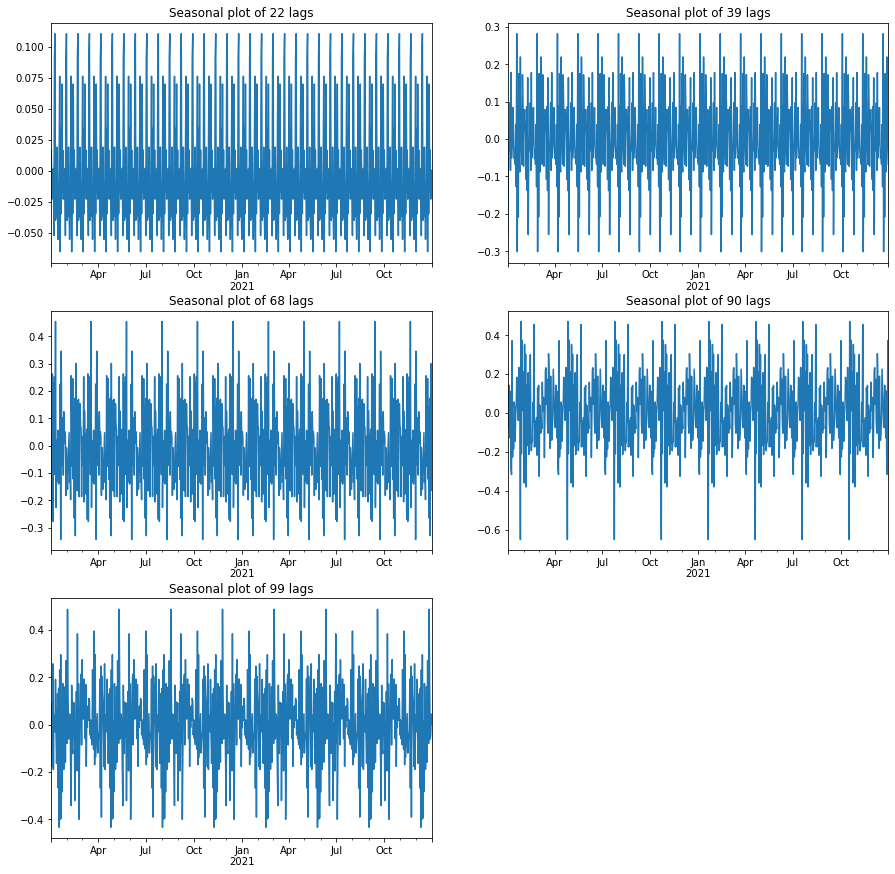

In [303]:
plt.figure(figsize=(15,15))

lags = [22, 39, 68, 90, 99]
i=1

for lag in lags:
    plt.subplot(3,2,i)
    Decompose = seasonal_decompose(clean_df, period=lag)
    Decompose.seasonal.plot()
    plt.title('Seasonal plot of %i lags' %lag,)
    i=i+1

#### confirmation of the lack of trends in the residuals of the decomposed series
Additionally, the plot of residuals shows that the residuals of the data do not have any noticeable trend.

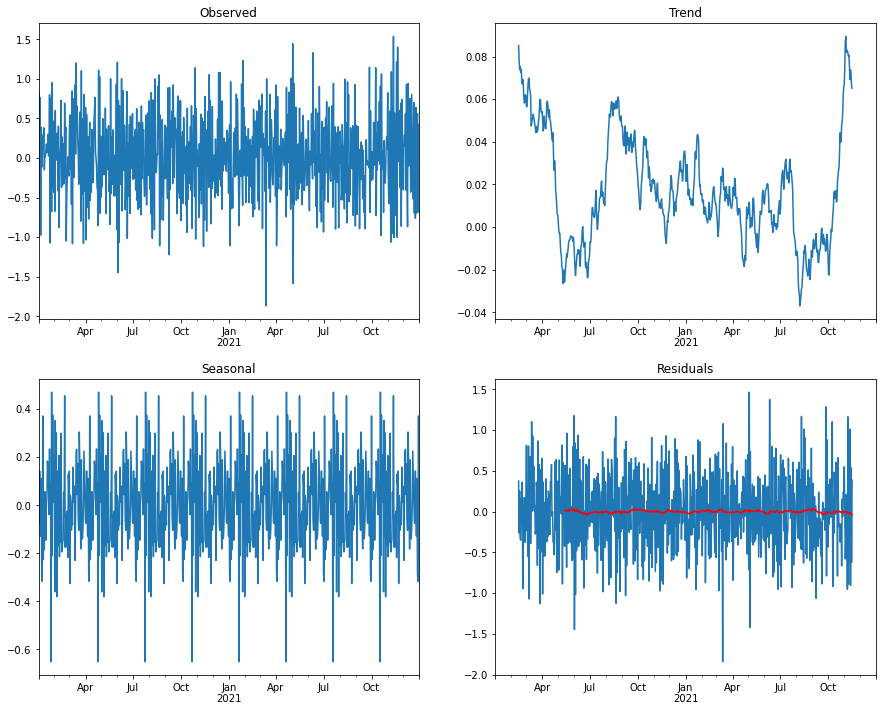

In [304]:
Decompose = seasonal_decompose(clean_df, period=90)

plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
Decompose.observed.plot()
plt.title('Observed')

plt.subplot(2,2,2)
Decompose.trend.plot()
plt.title('Trend')

plt.subplot(2,2,3)
Decompose.seasonal.plot()
plt.title('Seasonal')

plt.subplot(2,2,4)
Decompose.resid.plot()
Decompose.resid.rolling(90).mean().plot(c='r')
plt.title('Residuals');

### 2.  Identify an autoregressive integrated moving average (ARIMA) model that takes into account the observed trend and seasonality of the time series data.

In [305]:
data = train_df

aid_bic=[]

for p in range(0,2):
    for q in range(0,2):
        try:
            model = SARIMAX(train_df['Revenue'], order=(p,0,q),seasonal=True,
                            error_action='ignore', suppress_warnings=True)
            results = model.fit()
            
            aid_bic.append((p,q,results.aic,results.bic))
            
        except:
            print(p,q,None,None)
            
aid_bic = pd.DataFrame(aid_bic, columns=['p','q','aic','bic'])
print('The top (p,q) sorted by aic values: ')
print(aid_bic.sort_values('aic',ascending=True).head(1))
print(' ')
print('The top (p,q) sorted by bic values: ')
print(aid_bic.sort_values('bic',ascending=True).head(1))

The top (p,q) sorted by aic values: 
   p  q         aic         bic
2  1  0  774.990256  783.730058
 
The top (p,q) sorted by bic values: 
   p  q         aic         bic
2  1  0  774.990256  783.730058


Examining multiple p and q values and the resulting AIC and BIC values point to an ARIMA model of (1,0,0) being the most likely

In [306]:
model = SARIMAX(train_df, order=(1,0,0), seasonal_order=(1,0,0,90))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  584
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 90)   Log Likelihood                -383.200
Date:                            Thu, 07 Jul 2022   AIC                            772.400
Time:                                    20:39:58   BIC                            785.510
Sample:                                01-02-2020   HQIC                           777.510
                                     - 08-07-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4658      0.037    -12.510      0.000      -0.539      -0.393
ar.S.L90       0.0961      0.043      2.217      0.027       0.011       0.181
sigma2         0.2171      0.013     16.092      0.000       0.191       0.244
===================================================================================
Ljung-Box (Q):                       34.21   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.73   Prob(JB):                         0.66
Heteroskedasticity (H):               0.98   Skew:                            -0.06
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

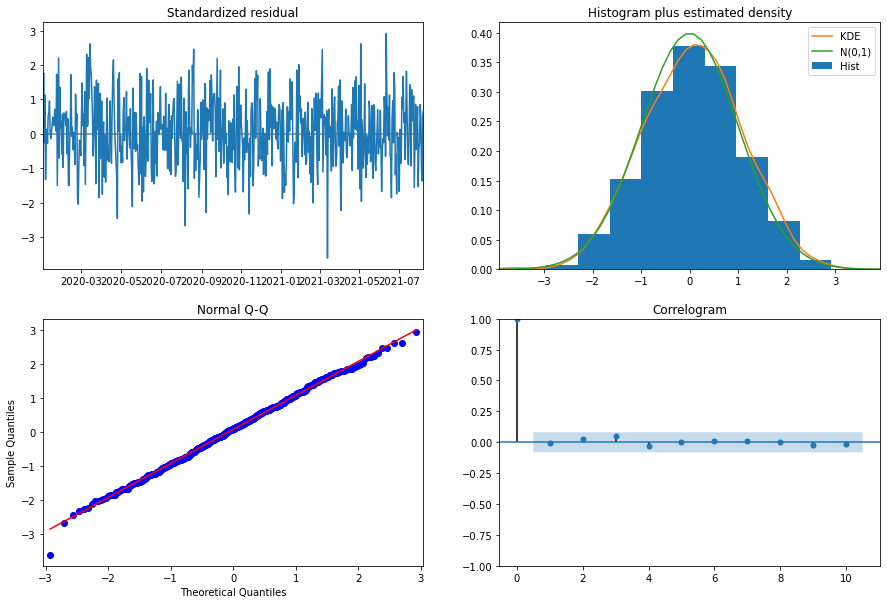

In [307]:
results.plot_diagnostics(figsize=(15,10))
plt.show()

Based on the results summary Prob(Q) value of 0.63 and Prob(JB) of 0.40 as well as the diagnostics plot visuals, the results of this ARIMA (1,0,0) are not correlated and are normally distributed.


In [308]:
automod = auto_arima(train_df, trace=True, seasonal=True, m=90, start_p=1, start_q=1, max_p=2, max_q=2, max_P=2, max_Q=2)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[90] intercept   : AIC=775.564, Time=16.01 sec
 ARIMA(0,0,0)(0,0,0)[90] intercept   : AIC=910.790, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[90] intercept   : AIC=771.587, Time=7.47 sec
 ARIMA(0,0,1)(0,0,1)[90] intercept   : AIC=798.728, Time=7.57 sec
 ARIMA(0,0,0)(0,0,0)[90]             : AIC=909.948, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[90] intercept   : AIC=773.893, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[90] intercept   : AIC=773.587, Time=39.12 sec
 ARIMA(1,0,0)(1,0,1)[90] intercept   : AIC=773.587, Time=13.87 sec
 ARIMA(1,0,0)(0,0,1)[90] intercept   : AIC=771.605, Time=6.07 sec
 ARIMA(1,0,0)(2,0,1)[90] intercept   : AIC=775.587, Time=51.46 sec
 ARIMA(0,0,0)(1,0,0)[90] intercept   : AIC=912.297, Time=3.85 sec
 ARIMA(2,0,0)(1,0,0)[90] intercept   : AIC=773.558, Time=7.91 sec
 ARIMA(1,0,1)(1,0,0)[90] intercept   : AIC=773.564, Time=9.74 sec
 ARIMA(0,0,1)(1,0,0)[90] intercept   : AIC=798.743, Time=7.61 sec
 ARIMA(2,0,1)(1,0,0)[90] inte

Finally, running an autu_arima function over the training data indicates that the best model for the data is an ARIMA(1,0,0)(1,0,0)[90] and will be used to build the forecast model

Once an order has been set, a training data model can be run and confirmed with the test data.
### Forecasted evaluation of training data versus test data

In [309]:
#SARIMAX model created using training data, modeled and fitted
training_model = SARIMAX(train_df, order=(1,0,0),seasonal_order=(1,0,0,90), trend='c',
                         error_action='ignore', suppress_warnings=True) 
training_results = training_model.fit()

In [310]:
#Finding the value of the final training data row after cumulating the sums of the difference data
first_date_val = train_df.cumsum().loc[train_df.index[-1]][0]

#Forecasting the data based on the results from the model for 147 days to match the length of the test data
forecast = training_results.get_forecast(steps=147)

#creating predicted means for the forecast
mean_forecast = forecast.predicted_mean.cumsum() + first_date_val

#creating confidence intervals for the forecast and setting the upper and lower limits of that interval based on a 95% confidence
confidence_intervals = forecast.conf_int(alpha=.05)
lower = confidence_intervals.iloc[:,0] + mean_forecast
upper = confidence_intervals.iloc[:,1] + mean_forecast

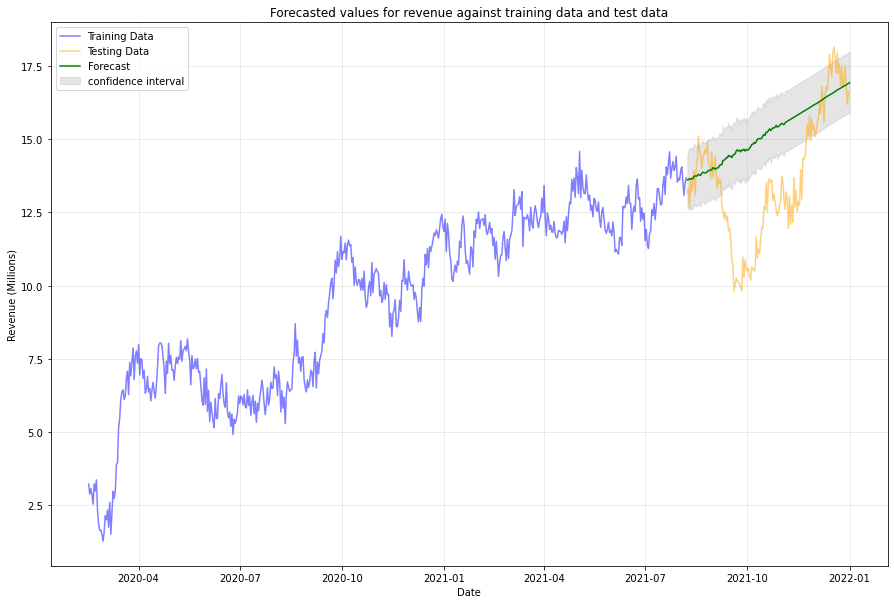

In [311]:
plt.figure(figsize=(15,10))

#Plot the training data by inverting the differenced values with a cumulative sum function
plt.plot(train_df.cumsum().iloc[45:], color='Blue', label='Training Data', Alpha=.5)

#plotting the testing data by inverting the values and adding the last value of the training data to match the original value at that index
plt.plot(test_df.cumsum() + train_df.cumsum().iloc[-1][0], color='Orange', label='Testing Data', Alpha=.5)

#Plotting the forecasted values from the model
plt.plot(mean_forecast.index, mean_forecast, color='Green', label='Forecast')

#Plotting the confidence interval limits
plt.fill_between(confidence_intervals.index, lower, upper, color='grey', alpha=.2, label='confidence interval')

plt.legend()
plt.title('Forecasted values for revenue against training data and test data')
plt.xlabel('Date')
plt.ylabel('Revenue (Millions)')
plt.grid(alpha=.3)
plt.show();

In [312]:
training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  584
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 90)   Log Likelihood                -381.794
Date:                            Thu, 07 Jul 2022   AIC                            771.587
Time:                                    20:43:29   BIC                            789.067
Sample:                                01-02-2020   HQIC                           778.400
                                     - 08-07-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0319      0.019      1.673      0.094      -0.005       0.069
ar.L1         -0.4681      0.037    -12.555      0.000      -0.541      -0.395
ar.S.L90       0.0929      0.043      2.157      0.031       0.008       0.177
sigma2         0.2161      0.013     16.159      0.000       0.190       0.242
===================================================================================
Ljung-Box (Q):                       34.43   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.72   Prob(JB):                         0.65
Heteroskedasticity (H):               0.98   Skew:                            -0.06
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [313]:
t = test_df.values
f = mean_forecast.values
print('The mean absolute error (MAE) of this prediction model is: ',np.mean(np.abs(t-f)))
print('The mean square error (MSE) of this prediction model is: ', np.mean(np.square(t-f)))
print('The root mean square error (RMSE) of this prediction model is: ', np.sqrt(np.mean(np.square(t-f))))

The mean absolute error (MAE) of this prediction model is:  15.192775174246272
The mean square error (MSE) of this prediction model is:  232.1423054516797
The root mean square error (RMSE) of this prediction model is:  15.23621690091342


### 3.  Perform a forecast using the derived ARIMA model.

In [314]:
model = SARIMAX(df, order=(1,1,0),seasonal_order=(1,1,0,90), trend='c',
                         error_action='ignore', suppress_warnings=True)
results = model.fit()

In [315]:
 #The prediction of this model, set to 180 days
forecast = results.get_forecast(steps=180)

#The predicted mean
mean_forecast = forecast.predicted_mean

#Establishing the lower and upper confidence limts for a %50 confidence interval
confidence_intervals_50 = forecast.conf_int(alpha=.5)
lower_50 = confidence_intervals_50.iloc[:,0]
upper_50 = confidence_intervals_50.iloc[:,1]

#Establishing the lower and upper confidence limts for a %95confidence interval
confidence_intervals_95 = forecast.conf_int(alpha=.05)
lower_95 = confidence_intervals_95.iloc[:,0]
upper_95 = confidence_intervals_95.iloc[:,1]

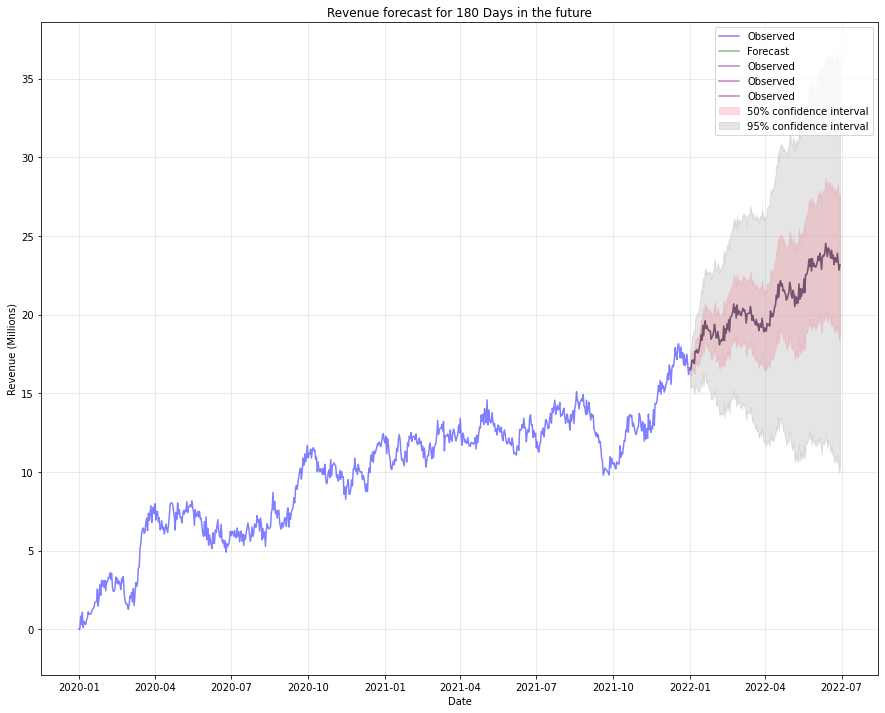

In [316]:
plt.figure(figsize=(15,12))

plt.plot(df, color='Blue', label='Observed', Alpha=.5)
plt.plot(mean_forecast.index, mean_forecast, color='Green', Alpha=.5, label='Forecast')
plt.plot(predictions, color='Purple', label='Observed', Alpha=.5)

plt.fill_between(confidence_intervals_50.index, lower_50, upper_50, color='pink', alpha=.6, label='50% confidence interval')
plt.fill_between(confidence_intervals_95.index, lower_95, upper_95, color='grey', alpha=.2, label='95% confidence interval')

plt.legend()
plt.title('Revenue forecast for 180 Days in the future')
plt.xlabel('Date')
plt.ylabel('Revenue (Millions)')
plt.grid(alpha=.3)
plt.show();

### 4.  Provide the output and calculations of the analysis you performed.

In [317]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  731
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 90)   Log Likelihood                -556.964
Date:                            Thu, 07 Jul 2022   AIC                           1121.929
Time:                                    20:44:10   BIC                           1139.775
Sample:                                01-01-2020   HQIC                          1128.856
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0030      0.024     -0.128      0.898      -0.050       0.043
ar.L1         -0.4948      0.035    -14.012      0.000      -0.564      -0.426
ar.S.L90      -0.4702      0.035    -13.384      0.000      -0.539      -0.401
sigma2         0.3221      0.017     18.739      0.000       0.288       0.356
===================================================================================
Ljung-Box (Q):                       43.20   Jarque-Bera (JB):                 2.80
Prob(Q):                              0.34   Prob(JB):                         0.25
Heteroskedasticity (H):               1.06   Skew:                            -0.11
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

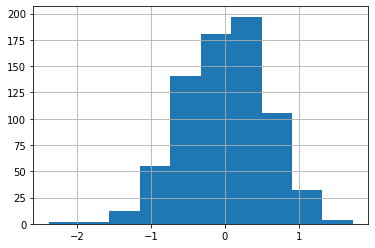

In [318]:
results.resid.hist();

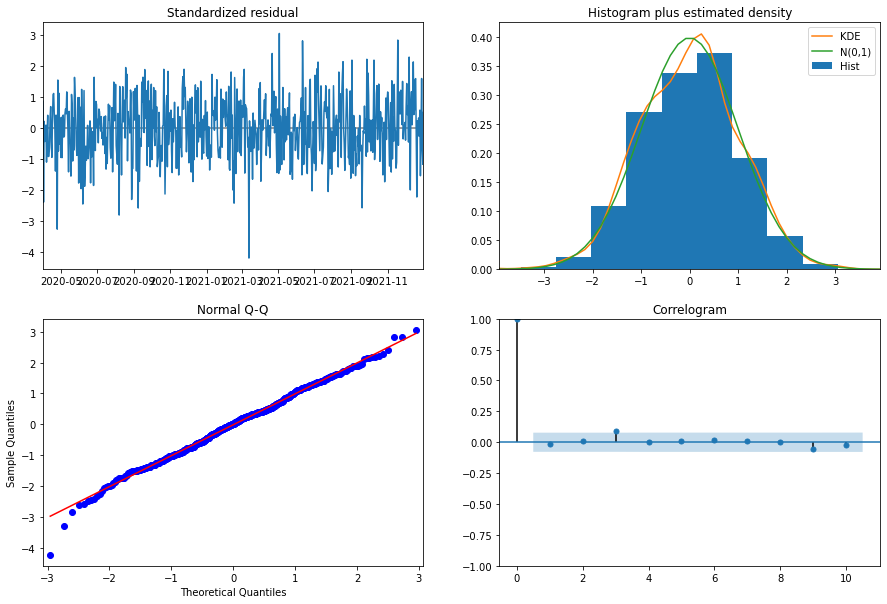

In [319]:
results.plot_diagnostics(figsize=(15,10));

In [320]:
predictions = pd.DataFrame(mean_forecast, columns=['Prediction'])
predictions['lower Revenue confidence'] = confidence_intervals['lower Revenue']
predictions['Upper Revenue confidence'] = confidence_intervals['upper Revenue']
predictions

,Prediction,lower Revenue confidence,Upper Revenue confidence
2022-01-01,16.491577,-1.007338,1.063458
2022-01-02,16.582056,NaN,NaN
2022-01-03,17.099371,NaN,NaN
2022-01-04,17.007716,NaN,NaN
2022-01-05,17.135293,NaN,NaN
...,...,...,...
2022-06-25,23.343376,NaN,NaN
2022-06-26,23.907989,NaN,NaN
2022-06-27,23.316954,NaN,NaN
2022-06-28,22.837296,NaN,NaN


### 5.  Provide the code used to support the implementation of the time series model.

see above

# Part V:  Data Summary and Implications
## E.  Summarize your findings and assumptions, including the following points:
### 1.  Discuss the results of your data analysis, including the following:
- #### the selection of an ARIMA model

Selecting the appropriate Arima model depended on the ACG and PACF returns results, testing multiple (p,q) orders in a SARIMAX model, and finally, an auto_arima function checking for varying orders alongside seasonal order.

The first two returned preferred values for a (1,0,0) model, and the auto_arima confirmed that order with the addition of seasonal order values of (1,0,0,90), which was used as selection for the final model.

- #### the prediction interval of the forecast

The training data for this model was built on daily revenue values. Prediction intervals for future values are the same 1-day interval

- #### a justification of the forecast length

With 730 days worth of revenue data, the model is suitable to predict for up to a year. However, each day past the last date of known data the model’s confidence interval’s upper and lower limits continue to expand. Therefore predictions further out can not be predicted accurately with much confidence.

To answer the research question and achieve the goal tasked by the telecom decision-makers, 180 days into the future would be a sufficient forecast length.

- #### the model evaluation procedure and error metric

Selecting the model order based on AIC was the primary model evaluation procedure. The final training model had an AIC value of 771.587

The error metrics for the training model based on the predicted values and the test data are:
-	Mean absolute error (MAE) of this prediction model is:  15.19
-	Mean square error (MSE) of this prediction model is:  232.14
-	Root mean square error (RMSE) of this prediction model is:  15.24

### 2.  Provide an annotated visualization of the forecast of the final model compared to the test set.

See section titled ” Forecasted evaluation of training data versus test data”


# Part VI:  Reporting
## F.  Create your report from part E using an industry-relevant interactive development environment (e.g., a Jupyter Notebook). Include a PDF or HTML document of your executed notebook presentation.

Attached

## G.  List the web sources used to acquire data or segments of third-party code to support the application.
Sun , X. (2018, August 20). Understand Arima and tune P, D, Q. Kaggle. Retrieved July 2022, from https://www.kaggle.com/code/sumi25/understand-arima-and-tune-p-d-q/notebook 

Scipy Lecture Notes. (n.d.). 1.6.12.9. spectrogram, power spectral density¶. 1.6.12.9. Spectrogram, power spectral density - Scipy lecture notes. Retrieved July 2022, from https://scipy-lectures.org/intro/scipy/auto_examples/plot_spectrogram.html 

Brownlee, J. (2020, December 9). How to decompose time series data into trend and seasonality. How to Decompose Time Series Data into Trend and Seasonality. Retrieved July 2022, from https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/ 


## H.  Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

“Time Series Analysis in Python” Datacamp, June-July 2022, https://app.datacamp.com/learn/courses/time-series-analysis-in-python

“ARIMA Models in Python” Datacamp, June-July 2022, https://app.datacamp.com/learn/courses/arima-models-in-python

Panopto. (2022). D213 Task 1 Webinar Video. Retrieved July 2022, from https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=efceba6c-e8ef-47a2-b859-aec400fe18e7. 
